# Q5. Face Recognition (15 pts)
Tóm tắt vấn đề: Nhận diện gương mặt
Cho tập dataset data_2_final.zip, chứa các hình ảnh gương mặt cần nhận diện của 100 người (identity) khác nhau.
File data.csv gồm 2 cột image – chứa tên ảnh, và label – chứa mã số identity của ảnh. Các ảnh có cùng label thuộc về cùng 1 người (identity).
Vận dụng những kiến thức đã học về Face Recognition, học viên hãy thực hiện các yêu cầu sau :
1. Sử dụng kiến trúc mô hình GhostFaceNet (2023) tiến hành xây dựng 1 mô hình nhận diện khuôn mặt cho tập dataset trên, sử dụng các pretrained weight sẵn có (học viên có thể tùy chọn pretrained weight). Đánh giá hiệu quả của mô hình trên tập data này thông qua Accuracy, True Positive Rate, False Positive Rate. Yêu cầu : Độ chính xác cao >98%.
2. Học viên tiến hành mô phỏng tình huống : Đăng ký thêm 1 identity vào ứng dụng Face Recognition sẵn có bằng việc thực hiện các bước sau :
A. Sử dụng kiến thức về Mean Face Embedding, tiến hành tạo 1 vector đại diện
cho mỗi identity (ví dụ : 100 identity sẽ có 100 vector đại diện)
B. Giả sử khi user mới đăng ký trong hệ thống, cần submit 2 tấm ảnh chân dung. Học viên hãy tự chọn 2 ảnh chân dung thuộc cùng 1 người bất kỳ (bản thân, bạn bè…) và tiến hành khởi tạo vector đại diện cho user mới này, add các thông tin về ID, filenames của 2 ảnh chân dung vào bộ data sẵn có.
3. Học viên tiến hành mô phỏng tình huống : 1 User login vào hệ thống Face
Recognition, bằng cách submit 1 tấm ảnh chân dung (lưu ý ảnh chân dung dùng để test trong câu hỏi này không được trùng với 2 ảnh đã submit ở câu hỏi 2, và phải thuộc cùng 1 identity). Tìm ID của ảnh vừa submit, kèm theo visualize các ảnh chân dung của ID đó trong dataset.

## 1. Sử dụng kiến trúc mô hình GhostFaceNet (2023) tiến hành xây dựng 1 mô hình nhận diện khuôn mặt cho tập dataset

## Implement Mean Face Enhancement Method

In [1]:
!pip install faiss-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 11.3 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!mkdir -p /content/input
!cp /content/drive/MyDrive/final_exam_dl_k291/Face-Recognition/data_2_final.zip /content/input/
%cd /content/input/
!unzip -qq data_2_final.zip

/content/input


In [4]:
import faiss
import numpy as np

In [5]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from sklearn.preprocessing import normalize
from sklearn.metrics import roc_curve, auc

In [6]:
dimensions = 512 #FaceNet output is 128 dimensional vector

metric = 'cosine' #euclidean, cosine

if metric == 'euclidean':
    index = faiss.IndexFlatL2(dimensions)
elif metric == 'cosine':
    index = faiss.IndexFlatIP(dimensions)
    # faiss.normalize_L2(emb)

In [7]:
!pip install tensorflow

### Step 1: Face Detection

In [8]:
!cp /content/drive/MyDrive/final_exam_dl_k291/Face-Recognition/face_detector.py face_detector.py
# copy file model face detection

### Crop face trong các ảnh test

In [9]:
from face_detector import YoloV5FaceDetector
folder_raw_face = "/content/drive/MyDrive/final_exam_dl_k291/Face-Recognition/test_cases/"
data_path = YoloV5FaceDetector().detect_in_folder(folder_raw_face)

181100504/181100504 [==============================] - 1s 0us/step


Detecting: 100%|██████████| 3/3 [00:09<00:00,  3.03s/it]

>>>> Saved aligned face images in: /content/drive/MyDrive/final_exam_dl_k291/Face-Recognition/test_cases_aligned_112_112


### Đánh giá hiệu quả của mô hình trên tập data này thông qua Accuracy, True Positive Rate, False Positive Rate. Yêu cầu : Độ chính xác cao >98%.

In [10]:
class Eval_image:
    def __init__(self, model_interf, img_path, output_dir,root_img_path):

        if isinstance(model_interf, str) and model_interf.endswith("h5"):
            model = tf.keras.models.load_model(model_interf)
            self.model_interf = lambda imms: model((imms - 127.5) * 0.0078125).numpy()
        else:
            self.model_interf = model_interf
        self.dist_func = lambda aa, bb: np.dot(aa, bb) # hàm tính khoảng cách giữa 2 vector
        self.output_dir = output_dir
        self.img_path = img_path
        print('begin serving')
        self.root_path = root_img_path
        self.embs, self.imm_classes, self.filenames = self.prepare_image_and_embedding(self.img_path, self.output_dir)

    def prepare_image_and_embedding(self, img_folder, output_dir):
        save_embeddings = output_dir
        # kiểm tra đường dẫn, nếu đã lưu các embedding vector vào file npz thì chỉ load lại
        if save_embeddings and os.path.exists(save_embeddings):
            print(">>>> Reloading from backup:", save_embeddings)
            aa = np.load(save_embeddings)
            embs, imm_classes, names = aa["embs"], aa["imm_classes"], aa["filenames"]
            embs, img_classes = embs.astype("float32"), imm_classes.astype("int")
        else:
            # chưa lưu => đọc mỗi hình
            img_shape = (112, 112)
            imgs = pd.read_csv('/content/input/data_2/data.csv')['image'].tolist() # danh sách tên các hình
            labels = pd.read_csv('/content/input/data_2/data.csv')['label'].tolist() # danh sách label của các hình
            embs = [] # list of embeddings
            img_classes = [] # list nhãn của mỗi hình (mỗi vector embedding)
            names = [] # list lưu tên file của mỗi hình
            for i,img_path in enumerate(tqdm(imgs)):
                img_path = os.path.join(self.root_path,img_path) # đọc file từng ảnh
                img = cv2.imread(img_path)
                img = cv2.resize(img, img_shape, interpolation=cv2.INTER_AREA)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = np.expand_dims(img, axis=0) # biến ảnh về kích thước (1,112,112,3)

                emb = self.model_interf(img) # lưu vector embedding
                emb = normalize(np.array(emb).astype("float32"))[0] # chuẩn hoá 1 vector theo L2 norm
                img_class = int(labels[i]) # nhãn của ảnh hiện tại
                img_classes.append(img_class) # lưu nhãn của ảnh hiện tại
                embs.append(emb) # lưu vector embedding của ảnh hiện tại
                filename = os.path.basename(img_path) # lấy filename (dạng abc.xyz)
                names.append(filename) # lưu filename của ảnh hiện tại
            # lưu tất cả thông tin trên vào 1 file npy
            np.savez(output_dir, embs=embs, imm_classes=img_classes, filenames=names)
            print("file chứa 4720 vector được save tại")
        return np.array(embs),np.array(img_classes),np.array(names)


    def do_evaluation(self):
        register_ids = np.unique(self.imm_classes) ## đếm xem có bao nhiêu identity trong dataset aka có bao nhiêu người có mặt trong dataset :D
        print(">>>> [base info] embs:", self.embs.shape, "imm_classes:", self.imm_classes.shape, "register_ids:", register_ids.shape)

        register_base_embs = np.array([]).reshape(0, self.embs.shape[-1]) # lưu vector đại diện của từng identity
        register_base_dists = []
        for register_id in tqdm(register_ids, "Evaluating"):
            # với từng identity: tìm các hình chứa gương mặt của người đó
            pos_pick_cond = self.imm_classes == register_id
            # lấy vector của các gương mặt đó
            pos_embs = self.embs[pos_pick_cond]
            # tạo ra vector đại diện cho identity đó : sum các vector gương mặt, sau đó normalize
            register_base_emb = normalize([np.sum(pos_embs, 0)])[0]
            # tính similarity của vector đại diện tới toàn bộ vector trong dataset
            register_base_dist = self.dist_func(self.embs, register_base_emb)
            register_base_dists.append(register_base_dist) # lưu kết quả vào 1 list
            register_base_embs = np.vstack([register_base_embs, register_base_emb])
        # save 1000 vector đại diện
        new_path = self.output_dir.replace(os.path.basename(self.output_dir),"processed_1000embedding.npz")
        print("saving vector đại diện tại: ",new_path)
        np.savez(new_path,embs =register_base_embs)
        register_base_dists = np.array(register_base_dists).T # similarity (cosine similarity) của toàn bộ identity tới toàn bộ vector trong dataset
        # cosine similarity from one image to each class
        print(register_base_dists.shape) # như vậy nó có shape 4720x1000

        # đồng thời theo chiều ngược lại : 1 ảnh (trong 4720 ảnh trong dataset), sẽ dc tính độ tương tự với 1000 vector đại diện
        ### bắt đầu quá trình tính toán accuracy

        # register_base_dists.argmax(1) => tìm identity tương tự nhất cho mỗi ảnh
        # accuracy = số lượng ảnh mà model detect identity đúng / số lượng ảnh (4720)
        accuracy = (register_base_dists.argmax(1) == self.imm_classes).sum() / register_base_dists.shape[0]
        print("register_ids shape: ",register_ids.shape)
        print("self.imm_classes shape: ",self.imm_classes.shape)

        # tạo 1 array có 4720 dòng x 1000 cột => mỗi dòng là 1 hình, hình dc predict có identity nào thì giá trị cột đó =1
        reg_pos_cond = np.equal(register_ids, np.expand_dims(self.imm_classes, 1))
        print(reg_pos_cond.shape) # array co 1 nghin cot, gia tri tai cot label =1

        # tính similarity của hình đó với vector identity gần nhất (positive prediction)
        reg_pos_dists = register_base_dists[reg_pos_cond].ravel()
        print(reg_pos_dists.shape) # 4720
        # similarity của các hình với các 999 vector identity xa hơn (999 negative prediction)
        reg_neg_dists = register_base_dists[np.logical_not(reg_pos_cond)].ravel()
        print(reg_neg_dists.shape) # 4720*999
        # turn it into a binary classification
        # label: tất cả prediction của model (positive hay negative) đều dc flatten
        # score: similarity tương ứng của model cho các quyết định đó
        label = np.concatenate([np.ones_like(reg_pos_dists), np.zeros_like(reg_neg_dists)])
        score = np.concatenate([reg_pos_dists, reg_neg_dists]) #distance tai cot co label va k co label
        return accuracy,score,label

def plot_tpr_far(score, label, new_figure=True, label_prefix=""):
    fpr, tpr, _ = roc_curve(label, score)
    roc_auc = auc(fpr, tpr)

    fpr_show = [10 ** (-ii) for ii in range(1, 7)[::-1]]
    fpr_reverse, tpr_reverse = fpr[::-1], tpr[::-1]
    tpr_show = [tpr_reverse[np.argmin(abs(fpr_reverse - ii))] for ii in fpr_show]
    print(pd.DataFrame({"FPR": fpr_show, "TPR": tpr_show}).set_index("FPR").T.to_markdown())

    try:
        import matplotlib.pyplot as plt

        fig = plt.figure() if new_figure else None
        label = "AUC = %0.4f%%" % (roc_auc * 100)
        if label_prefix and len(label_prefix) > 0:
            label = label_prefix + " " + label
        plt.plot(fpr, tpr, lw=1, label=label)
        plt.xlim([10 ** -6, 0.1])
        plt.xscale("log")
        plt.xticks(fpr_show)
        plt.xlabel("False Positive Rate")
        plt.ylim([0, 1.0])
        plt.yticks(np.linspace(0, 1.0, 8, endpoint=True))
        plt.ylabel("True Positive Rate")

        plt.grid(linestyle="--", linewidth=1)
        plt.title("ROC")
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.show()
    except:
        print("matplotlib plot failed")
        fig = None
    return fig

In [11]:
demo_image = Eval_image("/content/drive/MyDrive/final_exam_dl_k291/Face-Recognition/GhostFaceNet_W1.3_S1_ArcFace.h5", "/content/input/data_2/images", output_dir="/content/drive/MyDrive/final_exam_dl_k291/Face-Recognition/processed_100embedding.npz",root_img_path="/content/input/data_2/images")

begin serving


100%|██████████| 568/568 [02:26<00:00,  3.87it/s]

file chứa 4720 vector được save tại


>>>> [base info] embs: (568, 512) imm_classes: (568,) register_ids: (100,)


Evaluating: 100%|██████████| 100/100 [00:00<00:00, 1699.98it/s]


saving vector đại diện tại:  /content/drive/MyDrive/final_exam_dl_k291/Face-Recognition/processed_1000embedding.npz
(568, 100)
register_ids shape:  (100,)
self.imm_classes shape:  (568,)
(568, 100)
(568,)
(56232,)
|     |    1e-06 |    1e-05 |   0.0001 |    0.001 |     0.01 |      0.1 |
|:----|---------:|---------:|---------:|---------:|---------:|---------:|
| TPR | 0.598592 | 0.980634 | 0.982394 | 0.985915 | 0.991197 | 0.998239 |


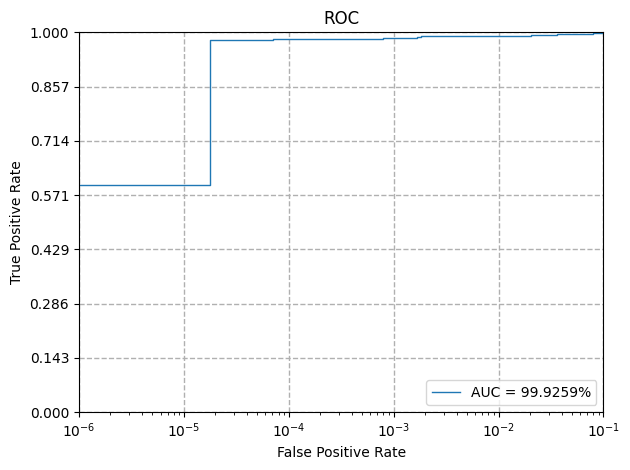

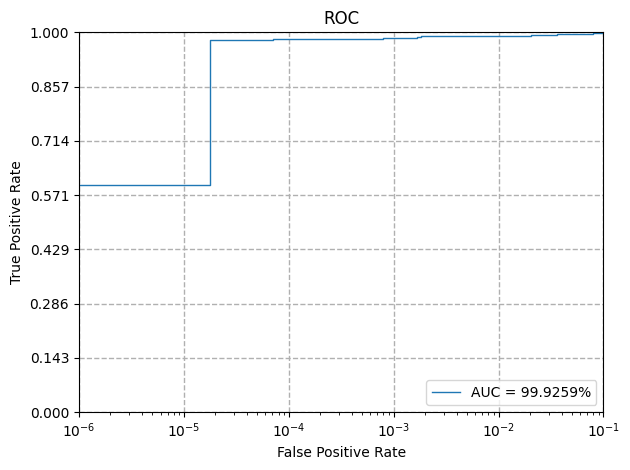

In [12]:
acc,scores,labels = demo_image.do_evaluation()
plot_tpr_far(scores, labels)

In [13]:
print("Accuracy:" , acc)

Accuracy: 0.9911971830985915


In [14]:
fpr, tpr, _ = roc_curve(labels, scores)
print("True Positive Rate: ", tpr)
print("False Positive Rate: ", fpr)

True Positive Rate:  [0.         0.00176056 0.59859155 0.59859155 0.9806338  0.9806338
 0.98239437 0.98239437 0.98415493 0.98415493 0.98591549 0.98591549
 0.98767606 0.98767606 0.98943662 0.98943662 0.99119718 0.99119718
 0.99295775 0.99295775 0.99471831 0.99471831 0.99647887 0.99647887
 0.99823944 0.99823944 1.         1.        ]
False Positive Rate:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.77834685e-05
 1.77834685e-05 7.11338740e-05 7.11338740e-05 8.00256082e-04
 8.00256082e-04 1.06700811e-03 1.06700811e-03 1.65386257e-03
 1.65386257e-03 1.81391379e-03 1.81391379e-03 2.11623275e-03
 2.11623275e-03 2.02553706e-02 2.02553706e-02 3.57269882e-02
 3.57269882e-02 6.40738370e-02 6.40738370e-02 7.92964860e-02
 7.92964860e-02 2.10147247e-01 2.10147247e-01 1.00000000e+00]


### Nhận xét:
- Dữ liệu embedding (embs) có kích thước (568, 512), có nghĩa là có 568 vector đại diện với mỗi vector có kích thước 512 chiều.
imm_classes có kích thước (568,), register_ids có kích thước (100,). Điều này có thể chỉ ra rằng có 568 ảnh được sử dụng trong quá trình đánh giá, và có 100 đối tượng (identity) được đăng ký.
- Mô hình đã được đánh giá trên 100 lượt thử nghiệm với mỗi giá trị ngưỡng khác nhau (1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1).
Kết quả của quá trình đánh giá được hiển thị dưới dạng bảng, với chỉ số True Positive Rate (TPR) cho mỗi giá trị ngưỡng.
- TPR tăng dần khi giá trị ngưỡng tăng, từ 0.598592 cho ngưỡng 1e-06 lên đến 0.998239 cho ngưỡng 0.1. Điều này có thể chỉ ra rằng mô hình đạt được hiệu suất tốt, đặc biệt là với các giá trị ngưỡng lớn.
- Đường cong ROC xuất hiện chạy sát theo góc trên bên trái của đồ thị, cho thấy trade-off giữa TPR và FPR khi giá trị ngưỡng thay đổi => mô hình có hiệu suất tốt.
- Mô hình có accurary cao: ~99.12%
- AUC=99.93%
=> Nhìn chung, hiệu quả của mô hình trên tập data này rất cao.

## 2. Mô phỏng tình huống : Đăng ký thêm 1 identity vào ứng dụng Face Recognition

In [15]:
aa = np.load("/content/drive/MyDrive/final_exam_dl_k291/Face-Recognition/processed_100embedding.npz")
embs, imm_classes, filename = aa["embs"], aa["imm_classes"], aa["filenames"]
emb, img_class = embs.astype("float32"), imm_classes.astype("int")
print(emb.shape)

(568, 512)


### A. Tiến hành tạo 1 vector đại diện cho mỗi identity

In [16]:
register_ids = np.unique(demo_image.imm_classes) ## đếm xem có bao nhiêu identity trong dataset aka có bao nhiêu người có mặt trong dataset :D
print(">>>> [base info] embs:", demo_image.embs.shape, "imm_classes:", demo_image.imm_classes.shape, "register_ids:", register_ids.shape)

register_base_embs = np.array([]).reshape(0, demo_image.embs.shape[-1]) # lưu vector đại diện của từng gương mặt
mean_embss = []
for register_id in tqdm(register_ids, "Evaluating"):
    # với từng identity: tìm các hình chứa gương mặt của người đó
    pos_pick_cond = demo_image.imm_classes == register_id
    # lấy vector của các gương mặt đó
    pos_embs = demo_image.embs[pos_pick_cond]
    # tạo ra vector đại diện cho identity đó : sum các vector gương mặt, sau đó normalize
    register_base_emb = normalize([np.sum(pos_embs, 0)])[0]
    mean_embss.append(register_base_emb)
mean_embss = np.array(mean_embss) #100 vector đại diện

>>>> [base info] embs: (568, 512) imm_classes: (568,) register_ids: (100,)


Evaluating: 100%|██████████| 100/100 [00:00<00:00, 4227.79it/s]


### B. Giả sử khi user mới đăng ký trong hệ thống, cần submit 2 tấm ảnh chân dung, tiến hành khởi tạo vector đại diện cho user mới này, add các thông tin về ID, filenames của 2 ảnh chân dung vào bộ data sẵn có

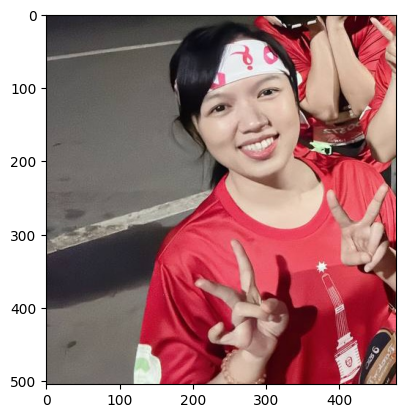

In [17]:
from matplotlib import pyplot as plt
plt.imshow(plt.imread("/content/drive/MyDrive/final_exam_dl_k291/Face-Recognition/test_cases/processed-215715ed-ba13-468f-9251-d4535d5a913c_gVK9CPPw.jpeg"))
plt.show()

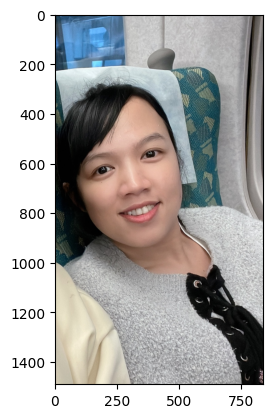

In [18]:
plt.imshow(plt.imread("/content/drive/MyDrive/final_exam_dl_k291/Face-Recognition/test_cases/processed-6fd4cb4d-d81b-4294-b5e0-de6b102c2700_9HMzh8ag.jpeg"))
plt.show()

In [19]:
## add a new person's embedding using some image
imgs = ["/content/drive/MyDrive/final_exam_dl_k291/Face-Recognition/test_cases_aligned_112_112/processed-215715ed-ba13-468f-9251-d4535d5a913c_gVK9CPPw.jpeg",
        "/content/drive/MyDrive/final_exam_dl_k291/Face-Recognition/test_cases_aligned_112_112/processed-6fd4cb4d-d81b-4294-b5e0-de6b102c2700_9HMzh8ag.jpeg"]
personal_embeddings = np.array([]).reshape(0, 512)
for img_path in imgs:
    # đọc và resize ảnh về kích thước 112,112
    img = cv2.imread(img_path)
    img = cv2.resize(img, (112,112), interpolation=cv2.INTER_AREA)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.expand_dims(img, axis=0) # (1,112,112,3)
    # single embeeding
    semb = demo_image.model_interf(img)
    # normalize từng embedding vector
    semb = normalize(np.array(semb).astype("float32"))[0]
    # lưu toàn bộ embedding vector vào 1 numpy array
    personal_embeddings = np.vstack([personal_embeddings, semb])
# tạo vector đại diện bằng cách tổng hợp các vector embedding đang có
p_pos_embs = personal_embeddings
p_register_base_emb = normalize([np.sum(p_pos_embs, 0)])[0]
# gắn vector đại diện mới vào danh sách các vector đại diện đang có
normalized_embeddings_new = np.vstack([mean_embss.copy(), p_register_base_emb])
print(normalized_embeddings_new.shape)

(101, 512)


In [20]:
imm_classes # image to class int

array([ 0,  0,  0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,
        4,  4,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  9,  9, 10, 10, 10, 11,
       11, 12, 12, 12, 12, 12, 12, 13, 13, 14, 14, 14, 15, 15, 15, 16, 16,
       16, 16, 16, 16, 17, 17, 17, 17, 18, 18, 18, 19, 19, 19, 19, 19, 19,
       19, 19, 19, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 21, 21,
       22, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 24, 24, 25, 25, 26, 26,
       26, 26, 27, 27, 27, 27, 28, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29,
       29, 29, 29, 30, 30, 30, 31, 31, 32, 32, 33, 33, 33, 34, 34, 34, 35,
       35, 35, 35, 35, 35, 35, 36, 36, 36, 36, 37, 37, 38, 38, 38, 38, 39,
       39, 40, 40, 40, 41, 41, 42, 42, 43, 43, 43, 43, 43, 43, 43, 43, 43,
       43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43,
       43, 43, 43, 43, 43, 43, 43, 44, 44, 44, 45, 45, 45, 45, 46, 46, 47,
       47, 48, 48, 49, 49

In [21]:
filename.shape

(568,)

## Adding new label and filenames to the system

In [22]:
## add new info
# idenity : 0 ---> 99
## add thêm 2 ảnh => thêm 2 label mới vào danh sách 568 label đang có
imm_classes_new = np.append(imm_classes, 100)
# 568 + 2
imm_classes_new = np.append(imm_classes_new, 100)
## add thêm 2 ảnh => thêm 2 file name mới vào danh sách 568 file name đang có

filename_new = np.append(filename, imgs[0])
filename_new = np.append(filename_new, imgs[1])


## Mô phỏng tình huống : 1 User login vào hệ thống Face Recognition, bằng cách submit 1 tấm ảnh chân dung. Tìm ID của ảnh vừa submit, kèm theo visualize các ảnh chân dung của ID đó trong dataset.

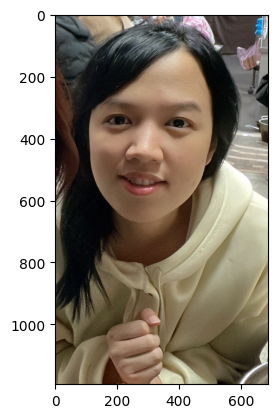

In [23]:
plt.imshow(plt.imread("/content/drive/MyDrive/final_exam_dl_k291/Face-Recognition/test_cases/processed-ea03e0c0-9d44-4365-854f-b823d5fa3802_BsQl4g9V.jpeg"))
plt.show()

In [24]:
img = cv2.imread("/content/drive/MyDrive/final_exam_dl_k291/Face-Recognition/test_cases_aligned_112_112/processed-ea03e0c0-9d44-4365-854f-b823d5fa3802_BsQl4g9V.jpeg")
img = cv2.resize(img, (112,112), interpolation=cv2.INTER_AREA)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = np.expand_dims(img, axis=0)
# single embeeding
semb = demo_image.model_interf(img)
semb = normalize(np.array(semb).astype("float32"))[0] # (512)

In [25]:
# register_ids = np.unique(imm_classes)
# mean_embss = np.load("processed_embedding.npz")['embs']

### Như vậy, chúng ta có thể tăng tốc độ tìm kiếm bằng cách : chỉ so sánh ảnh query với 101 vector đại diện thay vì so sánh với 568+2 vector hình ảnh như phương pháp trước đây

## Dùng faiss để so sánh

In [26]:
index.add(normalized_embeddings_new.astype(np.float32))

In [27]:
k = 1
target_representation = np.array(semb, dtype='f')
target_representation = np.expand_dims(target_representation, axis=0) # (1,512)
distances, neighbors = index.search(target_representation, k) # trả về  similarity và id của vector đại diện tương tự nhất với vector hiện tại

## Step 5: Visualizing the search results for the newly added person

In [28]:
distances[0]

array([0.7726206], dtype=float32)

ảnh query mà user dùng để checkin:


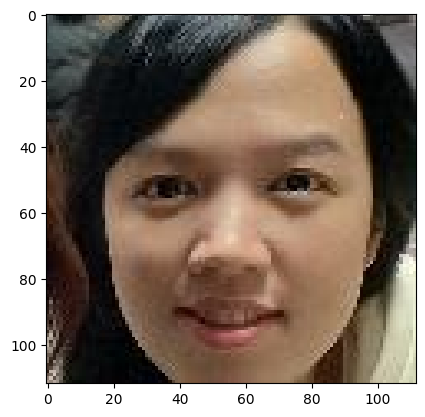

Hệ thống nhận thấy Ảnh query khớp với người có identity =  [100]
Dưới đây là các ảnh trong train dataset của người có identity =  [100]


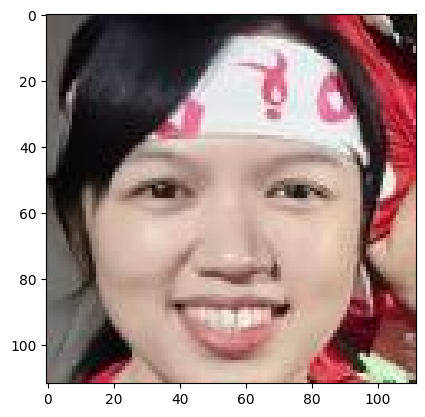

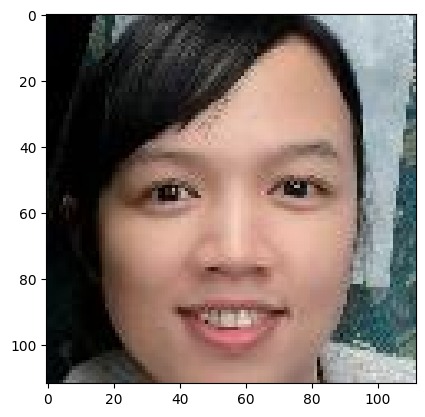

In [29]:
id_list = np.argwhere(imm_classes_new == neighbors.tolist()[0]) # tìm trong 568 ảnh ở tập train, ảnh nào có identity = neighbor hiện tại

print("ảnh query mà user dùng để checkin:")
plt.imshow(np.reshape(img,(112,112,3)))
plt.show()
print("Hệ thống nhận thấy Ảnh query khớp với người có identity = ",neighbors.tolist()[0])
print("Dưới đây là các ảnh trong train dataset của người có identity = ",neighbors.tolist()[0])
for i in id_list:
    im  = plt.imread(filename_new[i][0])
    plt.imshow(im)
    plt.show()

### Nhận xét:
- Mô phỏng cho ra kết quả tốt, mô hình có thể nhận dạng khuôn mặt tốt.